<a href="https://colab.research.google.com/github/dzmitter/Jupyter-Notebooks/blob/master/nb/chap02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The third edition of *Think Stats* is not for sale yet, but if you would like to support this project, please consider [buying me a coffee](https://buymeacoffee.com/allendowney).

# Distributions

This chapter introduces one of the most fundamental ideas in statistics, the distribution.
We'll start with frequency tables -- which represent the values in a dataset and the number of times each of them appears -- and use them to explore data from the National Survey of Family Growth (NSFG).
We'll also look for extreme or erroneous values, called outliers, and consider ways to handle them.

[Click here to run this notebook on Colab](https://colab.research.google.com/github/AllenDowney/ThinkStats/blob/v3/nb/chap02.ipynb).

In [1]:
from os.path import basename, exists


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)


download("https://github.com/AllenDowney/ThinkStats/raw/v3/nb/thinkstats.py")

Downloaded thinkstats.py


In [2]:
try:
    import empiricaldist
except ImportError:
    !pip install empiricaldist

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for empiricaldist: filename=empiricaldist-0.8.0-py3-none-any.whl size=12586 sha256=65f4c12d0d8a8384f9cd58996e0433f7c81bd2099f5729bb1bfb09a28c6c9505
  Stored in directory: /root/.cache/pip/wheels/ca/a9/1f/90c7a8a37ac37ff0fa0a27b2152f9b24be8910448ab93992f8
Successfully built empiricaldist


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from thinkstats import decorate

## Frequency Tables

One way to describe a variable is a **frequency table**, which contains the values of the variable and their **frequencies** -- that is, the number of times each value appears.
This description is called the **distribution** of the variable.

To represent distributions, we'll use a library called `empiricaldist`.
In this context, "empirical" means that the distributions are based on data rather than mathematical models.
`empiricaldist` provides a class called `FreqTab` that we can use to compute and plot frequency tables.
We can import it like this.

In [4]:
from empiricaldist import FreqTab

To show how it works, we'll start with a small list of values.

In [5]:
t = [1.0, 2.0, 2.0, 3.0, 5.0]

`FreqTab` provides a method called `from_seq` that takes a sequence and makes a `FreqTab` object.

In [6]:
ftab = FreqTab.from_seq(t)
ftab

,
1.0,1
2.0,2
3.0,1
5.0,1


A `FreqTab` object is a kind of Pandas `Series` that contains values and their frequencies.
In this example, the value `1.0` corresponds to frequency 1, the value `2.0` corresponds to frequency 2, etc.

`FreqTab` provides a method called `bar` that plots the frequency table as a bar chart.

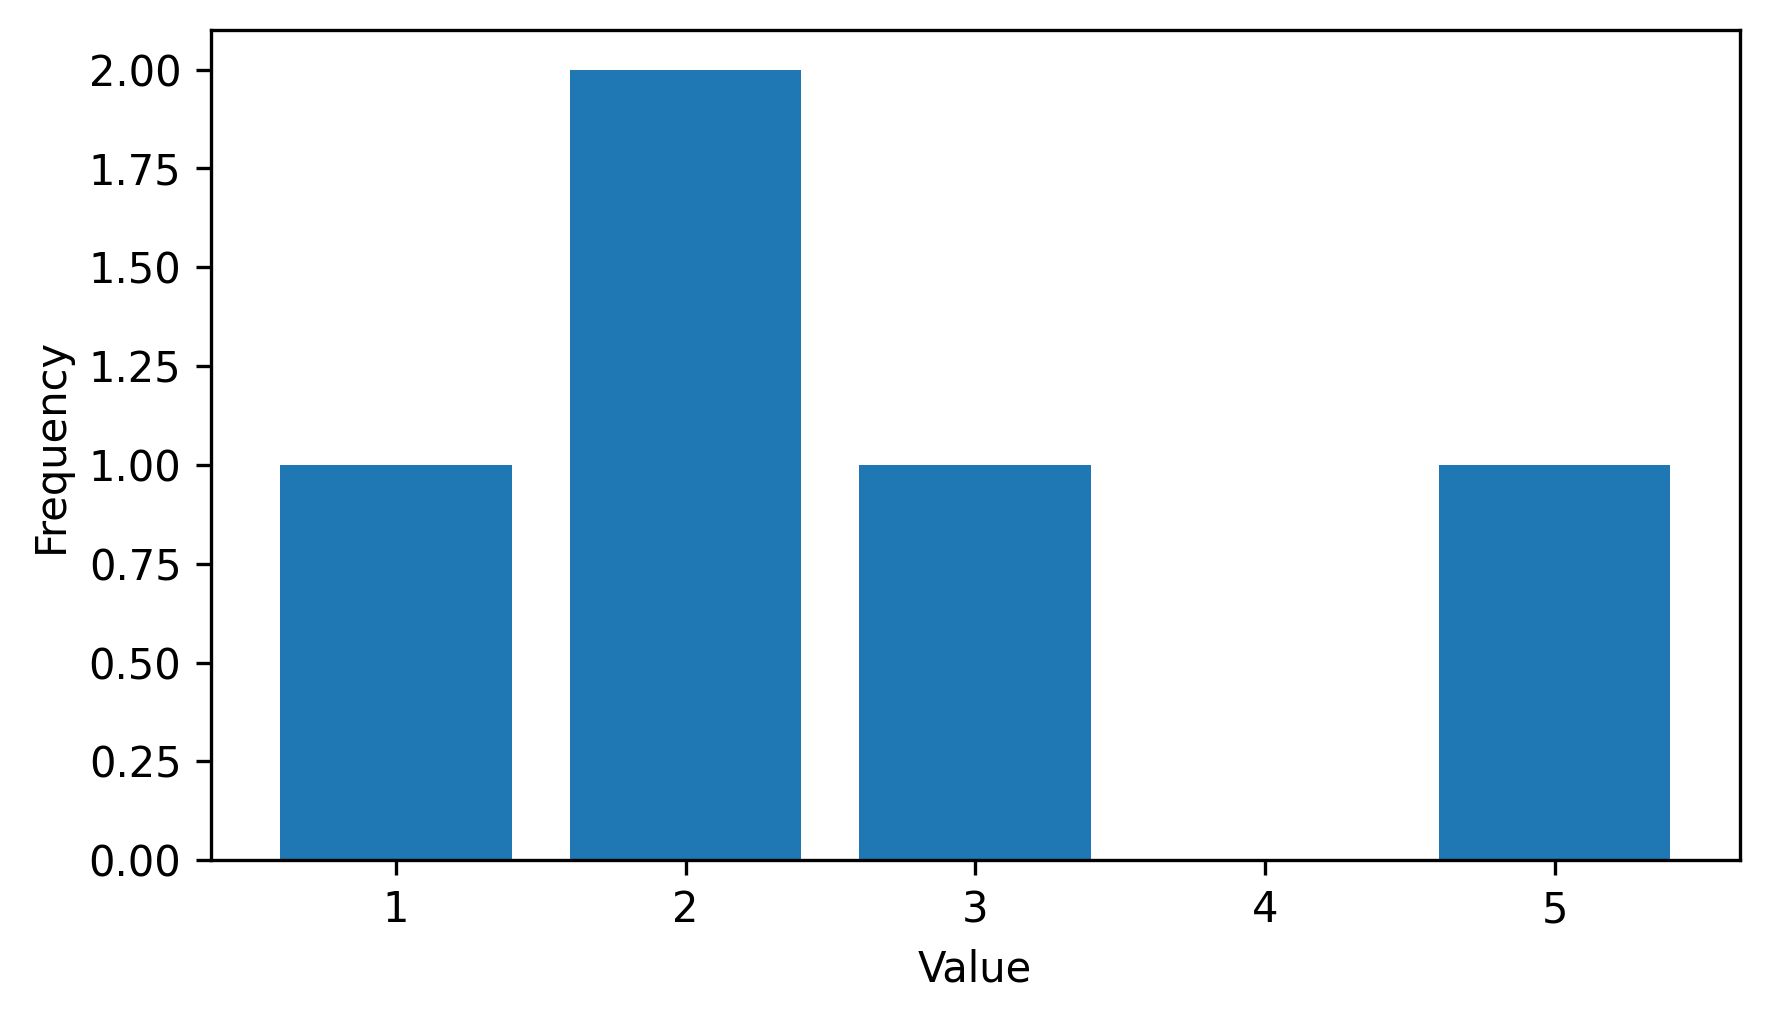

In [7]:
ftab.bar()
decorate(xlabel="Value", ylabel="Frequency")

Because a `FreqTab` is a Pandas `Series`, we can use the bracket operator to look up a value and get its frequency.

In [8]:
ftab[2.0]

np.int64(2)

But unlike a Pandas `Series`, we can also call a `FreqTab` object like a function to look up a value.

In [9]:
ftab(2.0)

np.int64(2)

If we look up a value that does not appear in the `FreqTab`, the function syntax returns `0`.

In [10]:
ftab(4.0)

0

A `FreqTab` object has an attribute called `qs` that returns an array of values -- `qs` stands for quantities, although technically not all values are quantities.

In [11]:
ftab.qs

array([1., 2., 3., 5.])

`FreqTab` also has an attribute called `fs` that returns an array of frequencies.

In [12]:
ftab.fs

array([1, 2, 1, 1])

`FreqTab` provides an `items` method we can use to loop through quantity-frequency pairs:

In [13]:
for x, freq in ftab.items():
    print(x, freq)

1.0 1
2.0 2
3.0 1
5.0 1


We'll see more `FreqTab` methods as we go along.

## NSFG Distributions

When you start working with a new dataset, I suggest you explore the variables you are planning to use one at a time, and a good way to start is by looking at frequency tables.

As an example, let's look at data from the National Survey of Family Growth (NSFG).
In the previous chapter, we downloaded this dataset, read it into a Pandas `DataFrame`, and cleaned a few of the variables.
The code we used to load and clean the data is in a module called `nsfg.py` -- instructions for installing this module are in the notebook for this chapter.

The following cells download the data files and install `statadict`, which we need to read the data.

In [14]:
try:
    import statadict
except ImportError:
    !pip install statadict

In [15]:
download("https://github.com/AllenDowney/ThinkStats/raw/v3/nb/nsfg.py")
download("https://github.com/AllenDowney/ThinkStats/raw/v3/data/2002FemPreg.dct")
download("https://github.com/AllenDowney/ThinkStats/raw/v3/data/2002FemPreg.dat.gz")

Downloaded nsfg.py
Downloaded 2002FemPreg.dct
Downloaded 2002FemPreg.dat.gz


We can import it and read the pregnancy file like this.

In [16]:
from nsfg import read_fem_preg

preg = read_fem_preg()

For the examples in this chapter, we'll focus on pregnancies that ended in live birth.
We can use the `query` method to select the rows where `outcome` is 1.

In [17]:
live = preg.query("outcome == 1")

In the string that's passed to `query`, variable names like `outcome` refer to column names in the `DataFrame`.
This string can also contain operators like `==` and operands like `1`.

Now we can use `FreqTab.from_seq` to count the number of times each quantity appears in `birthwgt_lb`, which is the pounds part of the birth weights.
The `name` argument gives the `FreqTab` object a name, which is used as a label when we plot it.

In [18]:
ftab_lb = FreqTab.from_seq(live["birthwgt_lb"], name="birthwgt_lb")

Here's what the distribution looks like.

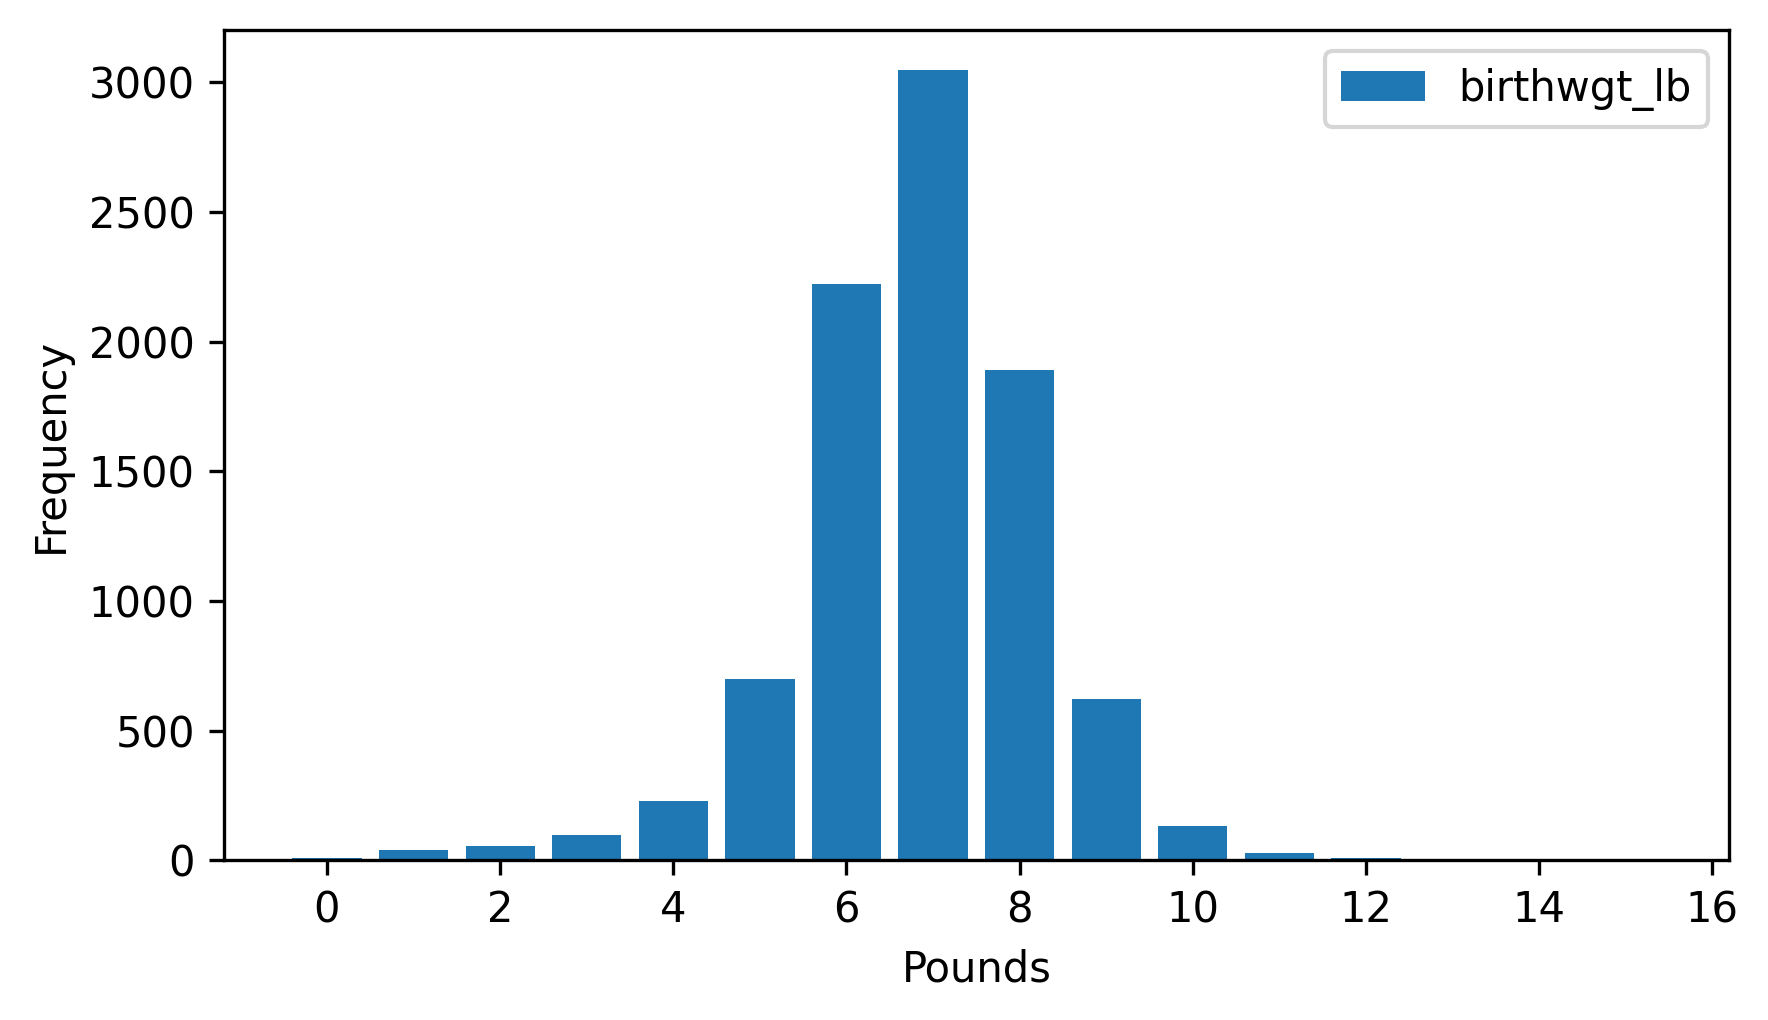

In [19]:
ftab_lb.bar()
decorate(xlabel="Pounds", ylabel="Frequency")

Looking at a distribution like this, the first thing we notice is the shape, which resembles the famous bell curve, more formally called a normal distribution or a Gaussian distribution.
The other notable feature of the distribution is the **mode**, which is the most common value.
To find the mode, we can use the method `idxmax`, which finds the quantity associated with the highest frequency.

In [20]:
ftab_lb.idxmax()

np.float64(7.0)

`FreqTab` provides a method called `mode` that does the same thing.

In [21]:
ftab_lb.mode()

np.float64(7.0)

In this distribution, the mode is at 7 pounds.

As another example, here's the frequency table of `birthwgt_oz`, which is the ounces part of birth weight.

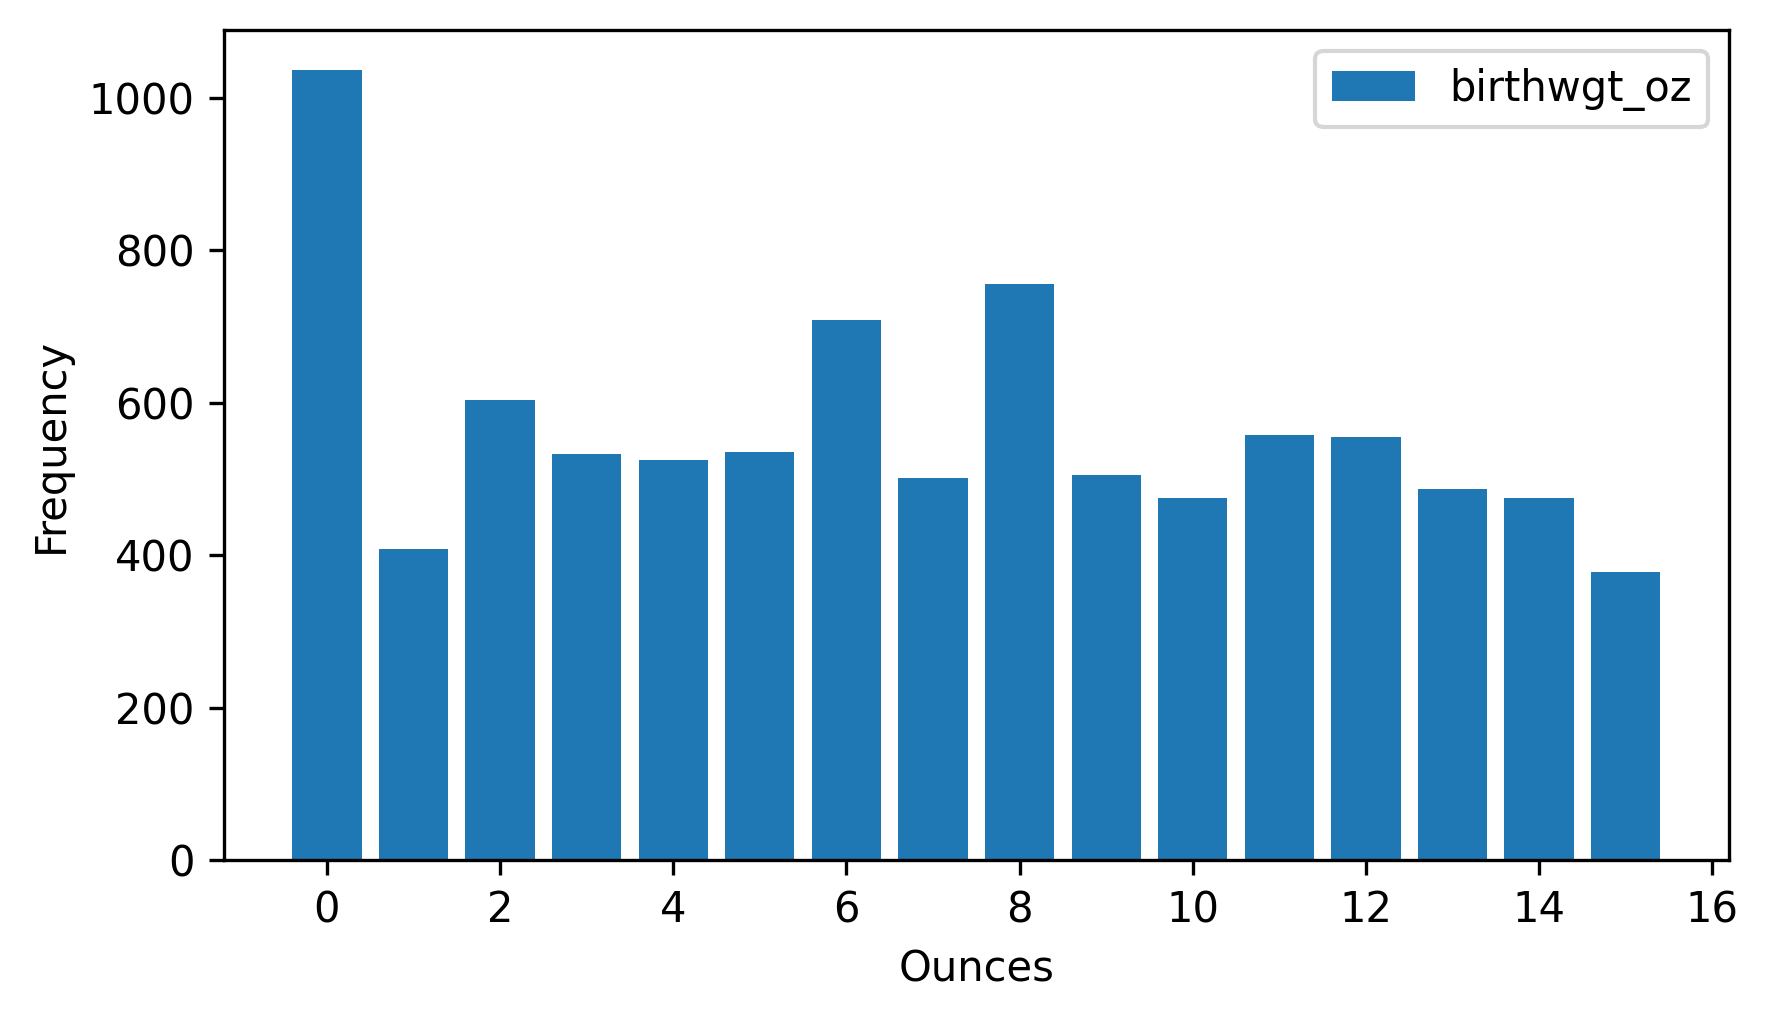

In [22]:
ftab_oz = FreqTab.from_seq(live["birthwgt_oz"], name="birthwgt_oz")
ftab_oz.bar()
decorate(xlabel="Ounces", ylabel="Frequency")

Because nature doesn't know about pounds and ounces, we might expect all values of `birthwgt_oz` to be equally likely -- that is, this distribution should be **uniform**.
But it looks like `0` is more common than the other quantities, and `1` and `15` are less common, which suggests that respondents round off birth weights that are close to a whole number of pounds.

As another example, let's look at the frequency table of `agepreg`, which is the mother's age at the end of pregnancy.

In [23]:
ftab_age = FreqTab.from_seq(live["agepreg"], name="agepreg")

In the NSFG, age is recorded in years and months, so there are more unique values than in the other distributions we've looked at.
For that reason, we'll pass `width=0.1` as a keyword argument to the `bar` method, which adjusts the width of the bars so they don't overlap too much.

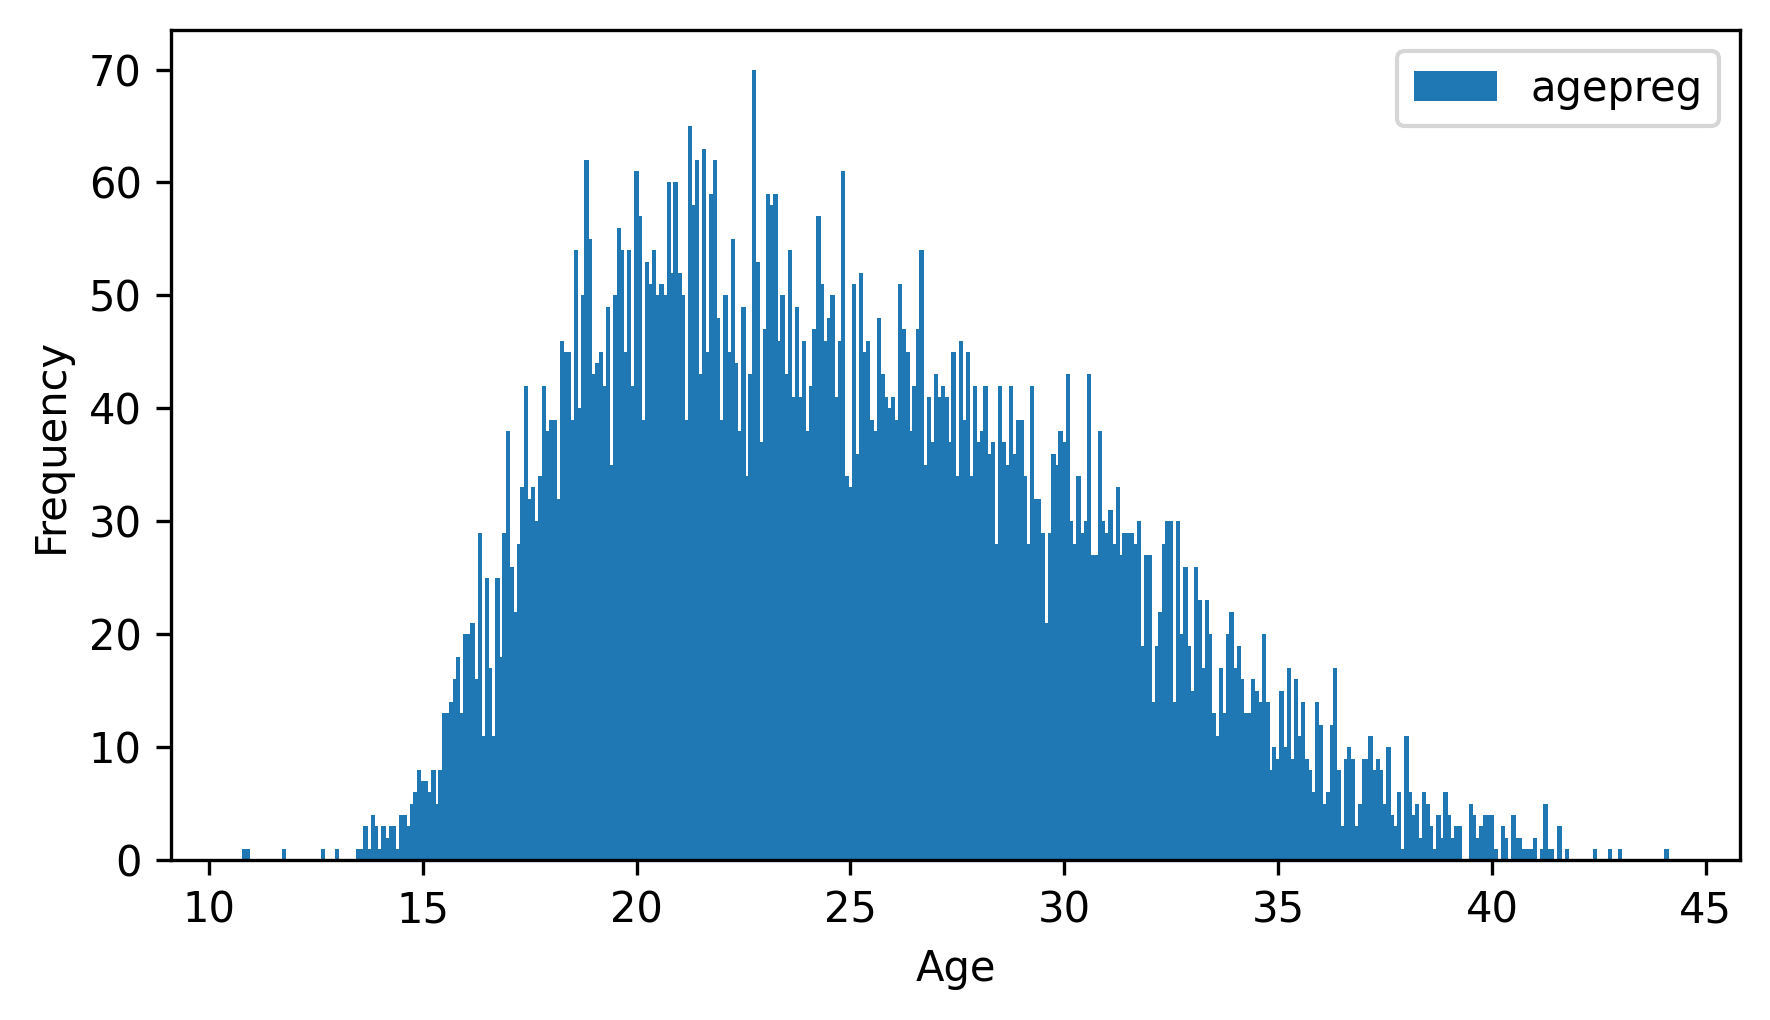

In [24]:
ftab_age.bar(width=0.1)
decorate(xlabel="Age", ylabel="Frequency")

The distribution is very roughly bell-shaped, but it is **skewed** to the right -- that is, the tail extends farther right than left.

Finally, let's look at the frequency table of `prglngth`, which is the length of the pregnancy in weeks.
The `xlim` argument sets the limit of the x-axis to the range from 20 to 50 weeks -- there are not many values outside this range, and they are probably errors.

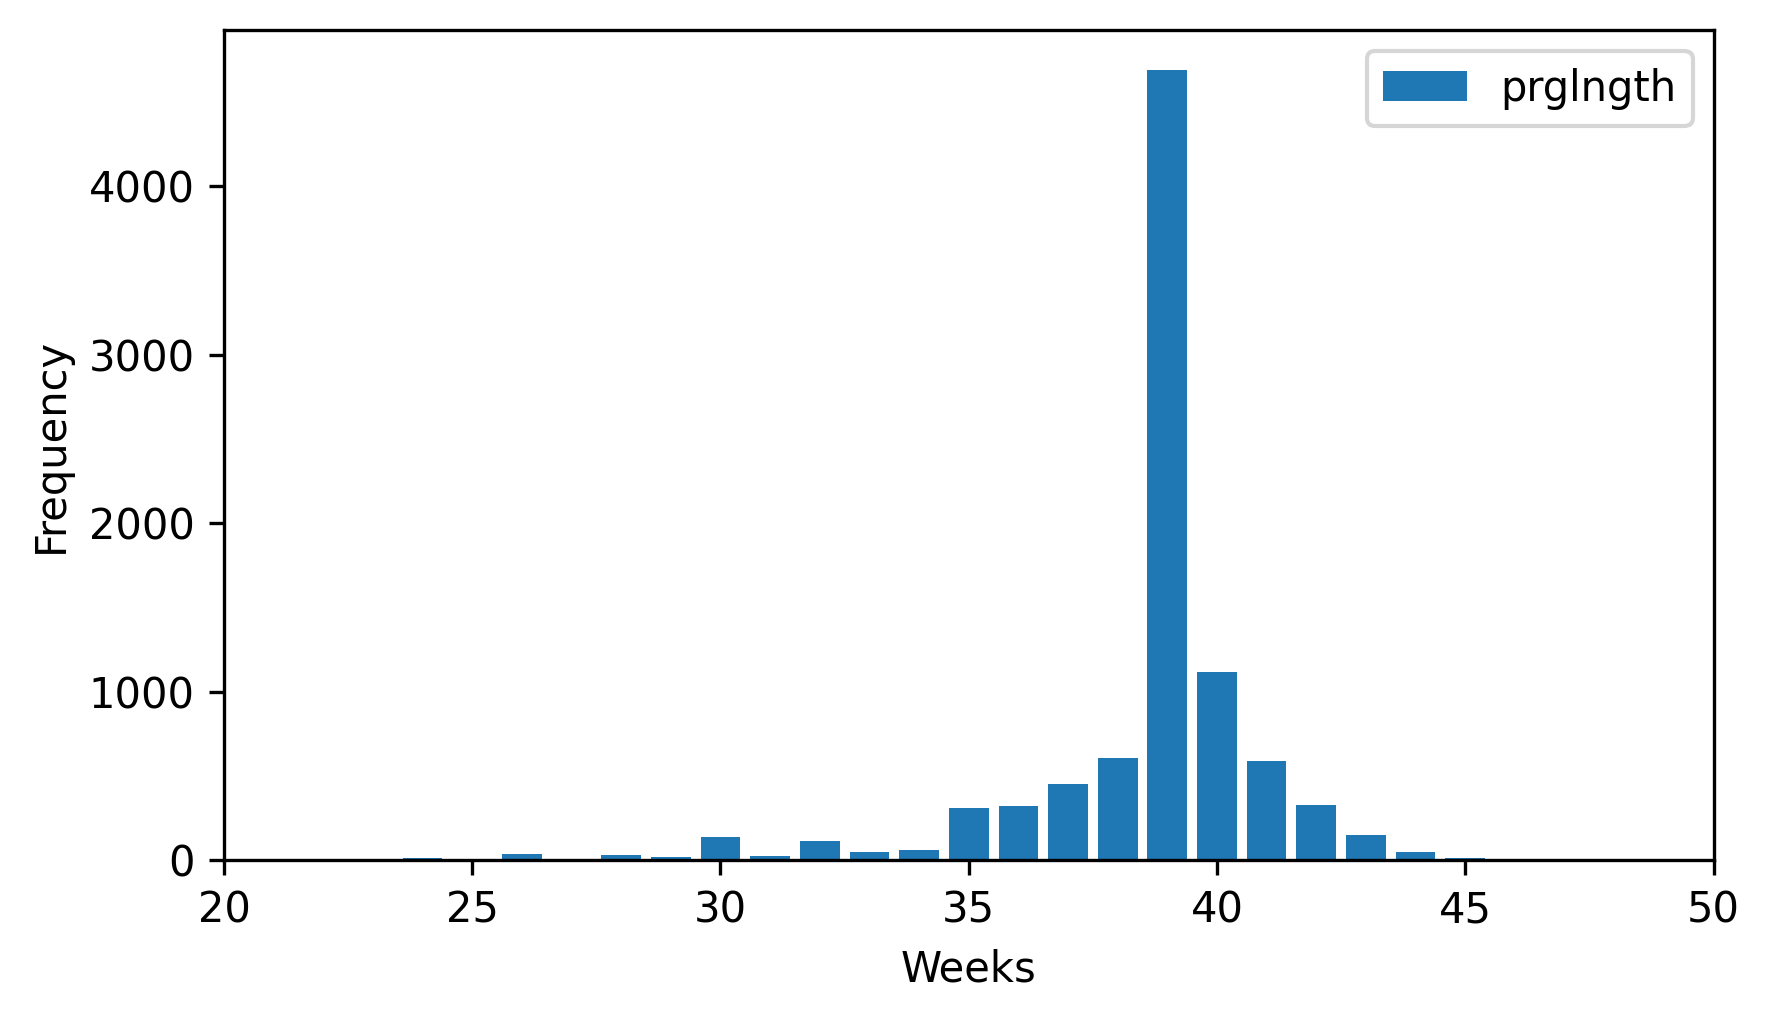

In [25]:
ftab_length = FreqTab.from_seq(live["prglngth"], name="prglngth")
ftab_length.bar()
decorate(xlabel="Weeks", ylabel="Frequency", xlim=[20, 50])

By far the most common quantity is 39 weeks.
The left tail is longer than the right -- early babies are common, but pregnancies seldom go past 43 weeks, and doctors often intervene if they do.

## Outliers

Looking at frequency tables, it is easy to identify the shape of the distribution and the most common quantities, but rare quantities are not always visible.
Before going on, it is a good idea to check for **outliers**, which are extreme values that might be measurement or recording errors, or might be accurate reports of rare events.

To identify outliers, the following function takes a `FreqTab` object and an integer `n`, and uses a slice index to select the `n` smallest quantities and their frequencies.

In [26]:
def smallest(ftab, n=10):
    return ftab[:n]

In the frequency table of `prglngth`, here are the 10 smallest values.

In [27]:
smallest(ftab_length)

,prglngth
prglngth,
0,1
4,1
9,1
13,1
17,2
18,1
19,1
20,1
21,2


Since we selected the rows for live births, pregnancy lengths less than 10 weeks are certainly errors.
The most likely explanation is that the outcome was not coded correctly.
Lengths higher than 30 weeks are probably legitimate.
Between 10 and 30 weeks, it is hard to be sure -- some quantities are probably errors, but some are correctly recorded preterm births.

The following function selects the largest values from a `FreqTab` object.

In [28]:
def largest(ftab, n=10):
    return ftab[-n:]

Here are the longest pregnancy lengths in the dataset.

In [29]:
largest(ftab_length)

,prglngth
prglngth,
40,1116
41,587
42,328
43,148
44,46
45,10
46,1
47,1
48,7


Again, some of these values are probably errors.
Most doctors recommend induced labor if a pregnancy exceeds 41 weeks, so 50 weeks seems unlikely to be correct.
But there is no clear line between values that are certainly errors and values that might be correct reports of rare events.

The best way to handle outliers depends on "domain knowledge" -- that is, information about where the data come from and what they mean.
And it depends on what analysis you are planning to perform.

In this example, the motivating question is whether first babies tend to be earlier or later than other babies.
So we'll use statistics that are not thrown off too much by a small number of incorrect values.

## First Babies

Now let's compare the distribution of pregnancy lengths for first babies and others.
We can use the `query` method to select rows that represent first babies and others.

In [30]:
firsts = live.query("birthord == 1")
others = live.query("birthord != 1")

And make a `FreqTab` of pregnancy lengths for each group.

In [31]:
ftab_first = FreqTab.from_seq(firsts["prglngth"], name="firsts")
ftab_other = FreqTab.from_seq(others["prglngth"], name="others")

The following function plots two frequency tables side-by-side.

In [32]:
def two_bar_plots(ftab1, ftab2, width=0.45):
    ftab1.bar(align="edge", width=-width)
    ftab2.bar(align="edge", width=width, alpha=0.5)

Here's what they look like.

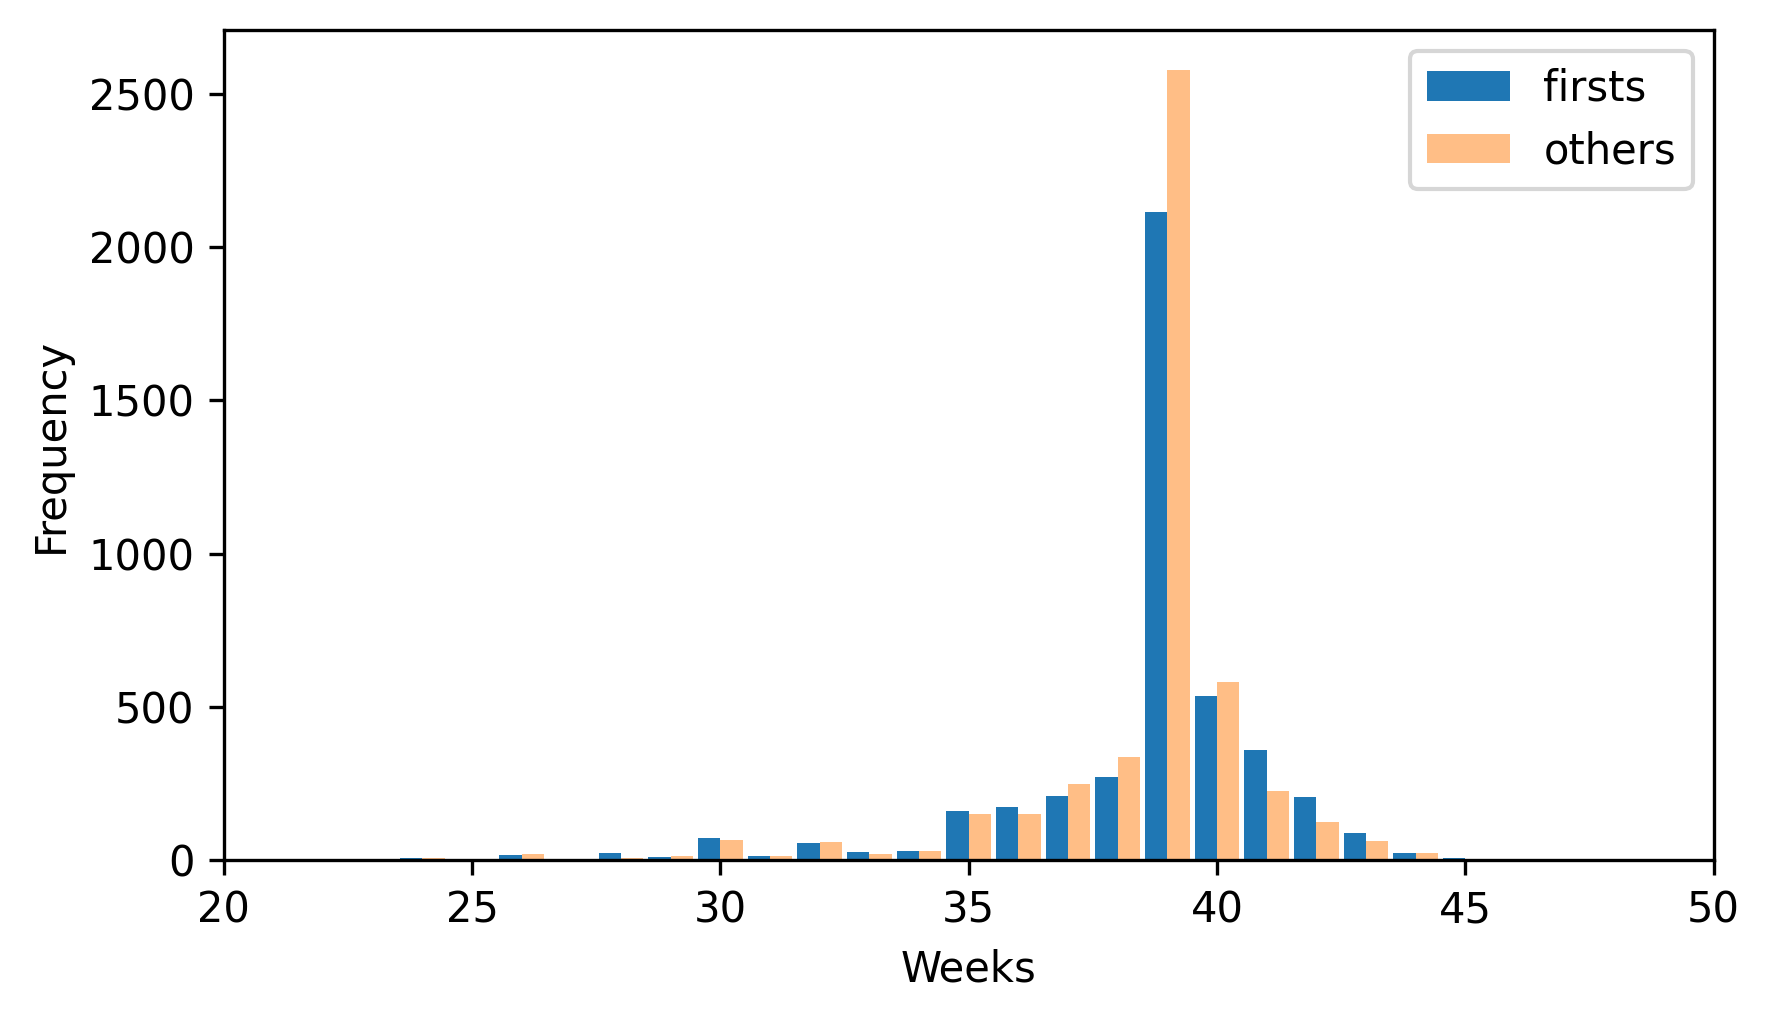

In [33]:
two_bar_plots(ftab_first, ftab_other)
decorate(xlabel="Weeks", ylabel="Frequency", xlim=[20, 50])

There is no obvious difference in the shape of the distributions or in the outliers.
It looks like more of the non-first babies are born during week 39, but there are more non-first babies in the dataset, so we should not compare the counts directly.

In [34]:
firsts["prglngth"].count(), others["prglngth"].count()

(np.int64(4413), np.int64(4735))

Comparing the means of the distributions, it looks like first babies are a little bit later on average.

In [35]:
first_mean = firsts["prglngth"].mean()
other_mean = others["prglngth"].mean()
first_mean, other_mean

(np.float64(38.60095173351461), np.float64(38.52291446673706))

But the difference is only 0.078 weeks, which is about 13 hours.

In [36]:
diff = first_mean - other_mean
diff, diff * 7 * 24

(np.float64(0.07803726677754952), np.float64(13.11026081862832))

There are several possible causes of this apparent difference:

* There might be an actual difference in average pregnancy length between first babies and others.

* The apparent difference we see in this dataset might be the result of bias in the sampling process -- that is, the selection of survey respondents.

* The apparent difference might be the result of measurement error -- for example, the self-reported pregnancy lengths might be more accurate for first babies or others.

* The apparent difference might be the result of random variation in the sampling process.

In later chapters, we will consider these possible explanations more carefully, but for now we will take this result at face value: in this dataset, there is a small difference in pregnancy length between these groups.

## Effect Size

A difference like this is sometimes called an "effect".
There are several ways to quantify the magnitude of an effect.
The simplest is to report the difference in absolute terms -- in this example, the difference is 0.078 weeks.

Another is to report the difference in relative terms.
For example, we might say that first pregnancies are 0.2% longer than others, on average.

In [37]:
diff / live["prglngth"].mean() * 100

np.float64(0.20237586646738304)

Another option is to report a **standardized** effect size, which is a statistic intended to quantify the size of an effect in a way that is comparable between different quantities and different groups.

Standardizing means we express the difference as a multiple of the standard deviation.
So we might be tempted to write something like this.

In [38]:
diff / live["prglngth"].std()

np.float64(0.028877623375210333)

But notice that we used both groups to compute the standard deviation.
If the groups are substantially different, the standard deviation when we put them together is larger than in either group, which might make the effect size seem small.

An alternative is to use the standard deviation of just one group, but it's not clear which. So we could take the average of the two standard deviations, but if the groups are different sizes, that would give too much weight to one group and not enough to the other.

A common solution is to use **pooled standard deviation**, which is the square root of pooled variance, which is the weighted sum of the variances in the groups.
To compute it, we'll start with the variances.

In [39]:
group1, group2 = firsts["prglngth"], others["prglngth"]

In [40]:
v1, v2 = group1.var(), group2.var()

Here is the weighted sum, with the group sizes as weights.

In [41]:
n1, n2 = group1.count(), group2.count()
pooled_var = (n1 * v1 + n2 * v2) / (n1 + n2)

Finally, here is the pooled standard deviation.

In [42]:
np.sqrt(pooled_var)

np.float64(2.702210814495382)

The pooled standard deviation is between the standard deviations of the groups.

In [43]:
firsts["prglngth"].std(), others["prglngth"].std()

(2.7919014146686947, 2.615852350439255)

A standardized effect size that uses pooled standard deviation is called **Cohen's effect size**. Here's a function that computes it.

In [44]:
def cohen_effect_size(group1, group2):
    diff = group1.mean() - group2.mean()

    v1, v2 = group1.var(), group2.var()
    n1, n2 = group1.count(), group2.count()
    pooled_var = (n1 * v1 + n2 * v2) / (n1 + n2)

    return diff / np.sqrt(pooled_var)

And here's the effect size for the difference in mean pregnancy lengths.

In [45]:
cohen_effect_size(firsts["prglngth"], others["prglngth"])

np.float64(0.028879044654449883)

In this example, the difference is 0.029 standard deviations, which is small.
To put that in perspective, the difference in height between men and women is about 1.7 standard deviations.

## Reporting results

We have seen several ways to describe the difference in pregnancy length (if there is one) between first babies and others.
How should we report these results?

The answer depends on who is asking the question.
A scientist might be interested in any (real) effect, no matter how small.
A doctor might only care about effects that are **practically significant** -- that is, differences that matter in practice.
A pregnant woman might be interested in results that are relevant to her, like the probability of delivering early or late.

How you report results also depends on your goals.
If you are trying to demonstrate the importance of an effect, you might choose summary statistics that emphasize differences.
If you are trying to reassure a patient, you might choose statistics that put the differences in context.

Of course your decisions should also be guided by professional ethics.
It's OK to be persuasive -- you *should* design statistical reports and visualizations that tell a story clearly.
But you should also do your best to make your reports honest, and to acknowledge uncertainty and limitations.

## Glossary


-   **distribution**: The set of values and how frequently each value appears in a dataset.

-   **frequency table**: A mapping from values to frequencies.

-   **frequency**: The number of times a value appears in a sample.

-   **skewed:** A distribution is skewed if it is asymmetrical, with extreme quantities extending farther in one direction than the other.

-   **mode**: The most frequent quantity in a sample, or one of the most frequent quantities.

-   **uniform distribution**: A distribution in which all quantities have the same frequency.

-   **outlier**: An extreme quantity in a distribution.

-   **standardized:** A statistic is standardized if it is expressed in terms that are comparable across different datasets and domains.

-   **pooled standard deviation:** A statistic that combines data from two or more groups to compute a common standard deviation.

-   **Cohen's effect size:** A standardized statistic that quantifies the difference in the means of two groups.

-   **practically significant:** An effect is practically significant if it is big enough to matter in practice.

## Exercises

For the exercises in this chapter, we'll load the NSFG female respondent file, which contains one row for each female respondent.
Instructions for downloading the data and the codebook are in the notebook for this chapter.

In [46]:
download("https://github.com/AllenDowney/ThinkStats/raw/v3/data/2002FemResp.dct")
download("https://github.com/AllenDowney/ThinkStats/raw/v3/data/2002FemResp.dat.gz")

Downloaded 2002FemResp.dct
Downloaded 2002FemResp.dat.gz


The codebook for the female respondent file is at <https://ftp.cdc.gov/pub/Health_Statistics/NCHS/Dataset_Documentation/NSFG/Cycle6Codebook-Female.pdf>.

The `nsfg.py` module provides a function that reads the female respondent file, cleans some of the variables, and returns a `DataFrame`.

In [47]:
from nsfg import read_fem_resp

resp = read_fem_resp()
resp.shape

(7643, 3092)

This `DataFrame` contains 3092 columns, but we'll use just a few of them.

### Exercise 2.1

We'll start with `totincr`, which records the total income for the respondent's family, encoded with a value from 1 to 14.
You can read the codebook for the respondent file to see what income level each value represents.

Make a `FreqTab` object to represent the distribution of this variable and plot it as a bar chart.

In [48]:
# Solution goes here

### Exercise 2.2

Make a frequency table of the `parity` column, which records the number of children each respondent has borne.
How would you describe the shape of this distribution?

In [49]:
# Solution goes here

In [50]:
# Solution goes here

Use the `largest` function to find the largest values of `parity`.
Are there any values you think are errors?

In [51]:
# Solution goes here

### Exercise 2.3

Let's investigate whether people with higher income bear more children.
Use the query method to select the respondents with the highest income (level 14).
Plot the frequency table of `parity` for just the high income respondents.

In [52]:
# Solution goes here

Compare the mean `parity` for high income respondents and others.

In [53]:
# Solution goes here

Compute Cohen's effect size for this difference.
How does it compare with the difference in pregnancy length for first babies and others?

In [54]:
# Solution goes here

Do these results show that people with higher income have more children, or can you think of another explanation for the apparent difference?

In [55]:
# Solution goes here

[Think Stats: Exploratory Data Analysis in Python, 3rd Edition](https://allendowney.github.io/ThinkStats/index.html)

Copyright 2024 [Allen B. Downey](https://allendowney.com)

Code license: [MIT License](https://mit-license.org/)

Text license: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/)